In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import learning_curve
%matplotlib inline

In [2]:
# Downloading dataset
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00332/OnlineNewsPopularity.zip
!unzip -o OnlineNewsPopularity.zip

# Loading data
df = pd.read_csv('OnlineNewsPopularity/OnlineNewsPopularity.csv')

# Displaying first few rows
print('First 5 rows:')
print(df.head())

# Dataset info
print('\nDataset Info:')
print(df.info())

--2025-05-25 21:18:35--  https://archive.ics.uci.edu/ml/machine-learning-databases/00332/OnlineNewsPopularity.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘OnlineNewsPopularity.zip’

OnlineNewsPopularit     [ <=>                ]   7.13M  45.2MB/s    in 0.2s    

2025-05-25 21:18:35 (45.2 MB/s) - ‘OnlineNewsPopularity.zip’ saved [7476401]

Archive:  OnlineNewsPopularity.zip
   creating: OnlineNewsPopularity/
  inflating: OnlineNewsPopularity/OnlineNewsPopularity.names  
  inflating: OnlineNewsPopularity/OnlineNewsPopularity.csv  
First 5 rows:
                                                 url   timedelta  \
0  http://mashable.com/2013/01/07/amazon-instant-...       731.0   
1  http://mashable.com/2013/01/07/ap-samsung-spon...       731.0   
2  http://mashable.com/2013/01/07/apple-40-billio

Missing Values: 0

Summary Statistics:
          timedelta  n_tokens_title  n_tokens_content  n_unique_tokens  \
count  39644.000000    39644.000000      39644.000000     39644.000000   
mean     354.530471       10.398749        546.514731         0.548216   
std      214.163767        2.114037        471.107508         3.520708   
min        8.000000        2.000000          0.000000         0.000000   
25%      164.000000        9.000000        246.000000         0.470870   
50%      339.000000       10.000000        409.000000         0.539226   
75%      542.000000       12.000000        716.000000         0.608696   
max      731.000000       23.000000       8474.000000       701.000000   

       n_non_stop_words  n_non_stop_unique_tokens     num_hrefs  \
count      39644.000000              39644.000000  39644.000000   
mean           0.996469                  0.689175     10.883690   
std            5.231231                  3.264816     11.332017   
min            0.000000   

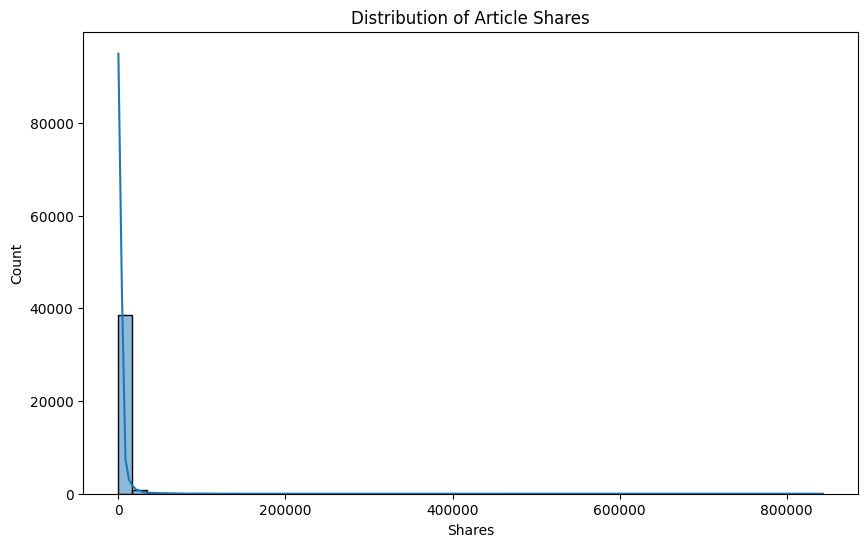

In [3]:
# Removing leading spaces from column names
df.columns = df.columns.str.strip()

# Checking for missing values
print('Missing Values:', df.isnull().sum().sum())

# Summary statistics
print('\nSummary Statistics:')
print(df.describe())

# Distribution of shares
plt.figure(figsize=(10, 6))
sns.histplot(df['shares'], bins=50, kde=True)
plt.title('Distribution of Article Shares')
plt.xlabel('Shares')
plt.show()

In [4]:
# Feature construction
# 1. Logging-transform word counts to reduce skewness
df['log_n_tokens_title'] = np.log1p(df['n_tokens_title'])
df['log_n_tokens_content'] = np.log1p(df['n_tokens_content'])

# 2. Sentiment polarity ratio
df['pos_neg_ratio'] = df['global_rate_positive_words'] / (df['global_rate_negative_words'] + 1e-5)

# 3. Content complexity (unique tokens ratio)
df['unique_token_ratio'] = df['n_unique_tokens'] / (df['n_tokens_content'] + 1e-5)

# Dropping non-predictive column
df = df.drop(['url'], axis=1)

# Binarizing target: shares > median = 1 (high), else 0 (low)
median_shares = df['shares'].median()
df['high_shares'] = (df['shares'] > median_shares).astype(int)
df = df.drop(['shares'], axis=1)

# Verifying feature count
print(f'Number of features: {len(df.columns) - 1}')

# X-y split
X = df.drop(['high_shares'], axis=1)
y = df['high_shares']

# Train-test split (for learning curves and final evaluation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizin features especially for SVM
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

Number of features: 63


In [5]:
# Initializing models
nb_clf = GaussianNB()
svm_clf = SVC(random_state=42)
rf_clf = RandomForestClassifier(random_state=42)

# Storing models and names
models = {
    'Naive Bayes': nb_clf,
    'SVM': svm_clf,
    'Random Forest': rf_clf
}

# Evaluating with 5-fold cross-validation
results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train_std, y_train, cv=5, scoring='accuracy')
    results[name] = {
        'Accuracy': np.mean(scores),
        'Accuracy Std': np.std(scores)
    }
    print(f'{name} - Mean Accuracy: {np.mean(scores):.4f} (±{np.std(scores):.4f})')

# Converting results to DataFrame
results_df = pd.DataFrame(results).T
print('\nCross-Validation Results:')
print(results_df)

Naive Bayes - Mean Accuracy: 0.5430 (±0.0331)
SVM - Mean Accuracy: 0.6573 (±0.0050)
Random Forest - Mean Accuracy: 0.6617 (±0.0057)

Cross-Validation Results:
               Accuracy  Accuracy Std
Naive Bayes    0.542992      0.033089
SVM            0.657323      0.004960
Random Forest  0.661737      0.005691


In [13]:
# hyperparameter grids
param_grids = {
    'Naive Bayes': {'var_smoothing': [1e-9, 1e-8, 1e-7]},  # Unchanged
    'SVM': {'C': [0.1, 1], 'kernel': ['rbf']},  # Reduced: 2 params, 6 fits
    'Random Forest': {'n_estimators': [50, 100], 'max_depth': [10, 20]}  # Reduced: 4 params, 12 fits
}

# Nested 3-fold CV for hyperparameter tuning
best_models = {}
for name, model in models.items():
    print(f'\nTuning {name}...')
    grid_search = GridSearchCV(model, param_grids[name], cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_std, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f'Best Parameters for {name}: {grid_search.best_params_}')


Tuning Naive Bayes...
Best Parameters for Naive Bayes: {'var_smoothing': 1e-09}

Tuning SVM...
Best Parameters for SVM: {'C': 1, 'kernel': 'rbf'}

Tuning Random Forest...
Best Parameters for Random Forest: {'max_depth': 10, 'n_estimators': 100}


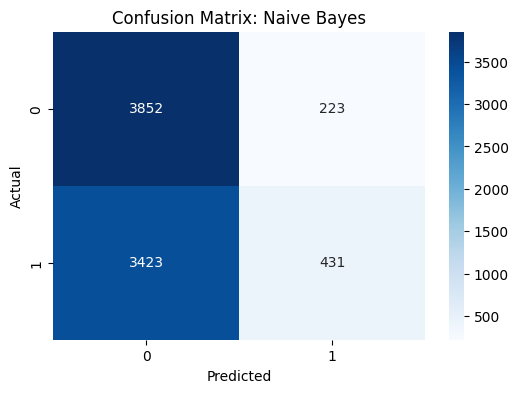

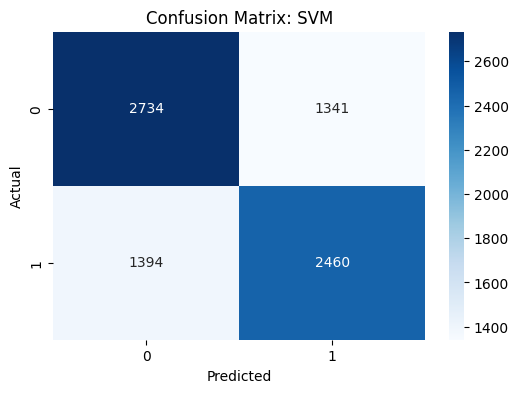

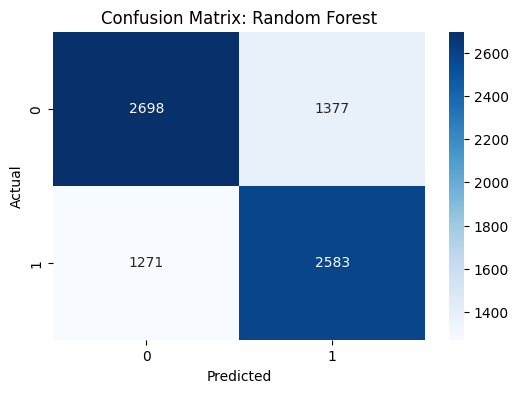


Final Test Set Results:
               Accuracy  F1-Score  Precision    Recall
Naive Bayes    0.540169  0.191216   0.659021  0.111832
SVM            0.655064  0.642717   0.647198  0.638298
Random Forest  0.666036  0.661121   0.652273  0.670213


In [14]:
# Evaluating best models on test set
final_results = {}
for name, model in best_models.items():
    y_pred = model.predict(X_test_std)
    final_results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred)
    }
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Converting final results to DataFrame
final_results_df = pd.DataFrame(final_results).T
print('\nFinal Test Set Results:')
print(final_results_df)

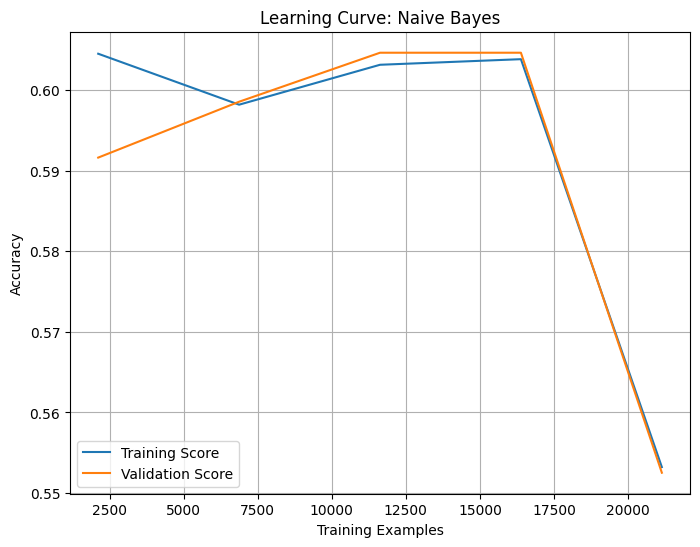

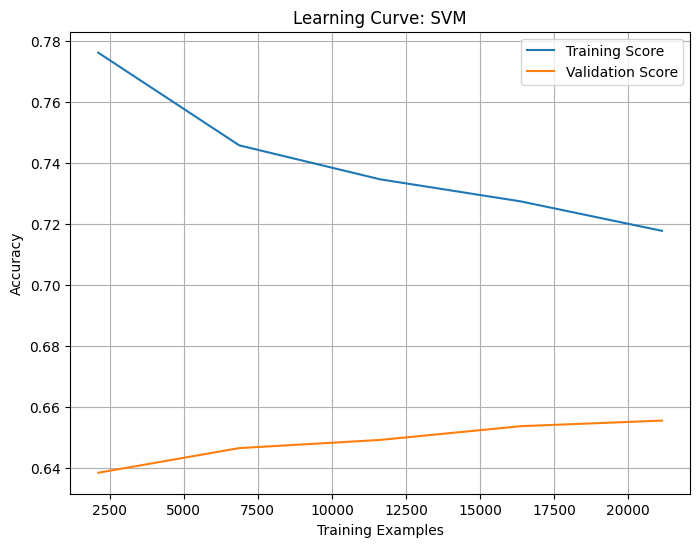

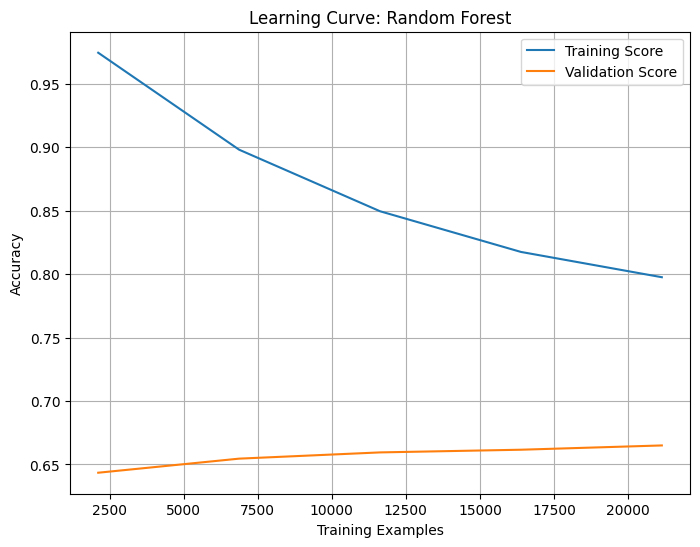

In [16]:
for name, model in best_models.items():
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train_std, y_train, cv=3, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
    )
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Score')
    plt.plot(train_sizes, val_scores.mean(axis=1), label='Validation Score')
    plt.title(f'Learning Curve: {name}')
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.savefig(f'{name}_learning_curve.png')  # Save plot
    plt.show()